<a href="https://colab.research.google.com/github/spouladchang/Mountain-Car-RL-Optimization/blob/main/MountainCar_Discretization_and_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MountainCar-v0 Reinforcement Learning (Q-Learning)**

This notebook implements a Q-Learning agent to solve the classic MountainCar-v0 challenge. The goal is to drive an underpowered car up a steep hill by building momentum.

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

# Global constants for the environment
ENV_NAME = 'MountainCar-v0'

**Environment Analysis**

Before training, we need to understand the State Space and Action Space.
1. Observation Space (Continuous)

The state consists of two continuous values:

    Position: Range [-1.2, 0.6]

    Velocity: Range [-0.07, 0.07]

2. Action Space (Discrete)



There are 3 discrete deterministic actions:

| Num | Observation             | Value | Unit         |
|-----|-------------------------|-------|--------------|
| 0   | Accelerate to the left  | Inf   | position (m) |
| 1   | Don't accelerate        | Inf   | position (m) |
| 2   | Accelerate to the right | Inf   | position (m) |



Observation Space High: [0.6  0.07]
Observation Space Low: [-1.2  -0.07]
Action Space Size: 3


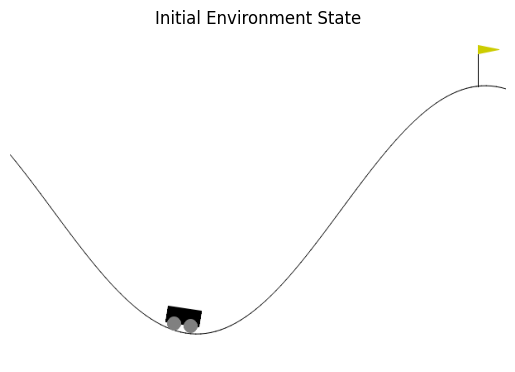

In [2]:
env = gym.make(ENV_NAME, render_mode="rgb_array")
state, info = env.reset()

print(f"Observation Space High: {env.observation_space.high}")
print(f"Observation Space Low: {env.observation_space.low}")
print(f"Action Space Size: {env.action_space.n}")

# Show initial state
plt.imshow(env.render())
plt.axis('off')
plt.title("Initial Environment State")
plt.show()

**Discretization Strategy**

Since the state space is continuous, we cannot use it directly as keys in a Q-Table. We divide the range into small "Buckets" to create a grid.

In [3]:
LOWER_BOUNDS = [-1.2, -0.07]
UPPER_BOUNDS = [0.6, 0.07]
BUCKETS = (20, 20) # 20 segments for position, 20 for velocity

def discretize(state):
    """Maps continuous state to a discrete grid index."""
    discrete_state = []
    for i in range(len(state)):
        # Calculate where the value falls within the range (0.0 to 1.0)
        scaling = (state[i] - LOWER_BOUNDS[i]) / (UPPER_BOUNDS[i] - LOWER_BOUNDS[i])
        # Convert to integer index based on bucket size
        new_index = int(scaling * BUCKETS[i])
        # Clip values to stay within bucket indices
        new_index = min(BUCKETS[i] - 1, max(0, new_index))
        discrete_state.append(new_index)
    return tuple(discrete_state)

**Q-Learning Implementation**

We use the Epsilon-Greedy strategy for exploration and the Bellman Equation to update the Q-values

In [4]:
def select_action(q_table, state_idx, action_space, epsilon):
    """Exploration vs Exploitation."""
    if np.random.random() < epsilon:
        return action_space.sample()
    return np.argmax(q_table[state_idx])

def train_q_learning(env, episodes=10000, lr=0.1, gamma=0.99):
    q_table_shape = BUCKETS + (env.action_space.n,)
    q_table = np.zeros(q_table_shape)

    epsilon = 1.0
    min_epsilon = 0.1
    decay_rate = 0.995
    rewards_history = []

    for episode in range(episodes):
        obs, _ = env.reset()
        state = discretize(obs)
        total_reward = 0
        done = False

        while not done:
            action = select_action(q_table, state, env.action_space, epsilon)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            next_state = discretize(next_obs)

            # Q-Table Update Rule
            old_value = q_table[state][action]
            next_max = np.max(q_table[next_state])
            q_table[state][action] = (1 - lr) * old_value + lr * (reward + gamma * next_max)

            state = next_state
            total_reward += reward
            done = terminated or truncated

        if epsilon > min_epsilon:
            epsilon *= decay_rate

        rewards_history.append(total_reward)
        if episode % 1000 == 0:
            print(f"Episode: {episode}, Score: {total_reward}, Epsilon: {epsilon:.2f}")

    return q_table, np.argmax(q_table, axis=2), rewards_history

In [5]:
# Create training env without heavy rendering
train_env = gym.make(ENV_NAME)
q_table, policy, scores = train_q_learning(train_env, episodes=10000)
print("✅ Training Complete!")

Episode: 0, Score: -200.0, Epsilon: 0.99
Episode: 1000, Score: -200.0, Epsilon: 0.10
Episode: 2000, Score: -200.0, Epsilon: 0.10
Episode: 3000, Score: -174.0, Epsilon: 0.10
Episode: 4000, Score: -169.0, Epsilon: 0.10
Episode: 5000, Score: -160.0, Epsilon: 0.10
Episode: 6000, Score: -176.0, Epsilon: 0.10
Episode: 7000, Score: -196.0, Epsilon: 0.10
Episode: 8000, Score: -180.0, Epsilon: 0.10
Episode: 9000, Score: -200.0, Epsilon: 0.10
✅ Training Complete!


**Visualization and Results**

Now we visualize the learning progress and animate the trained agent.

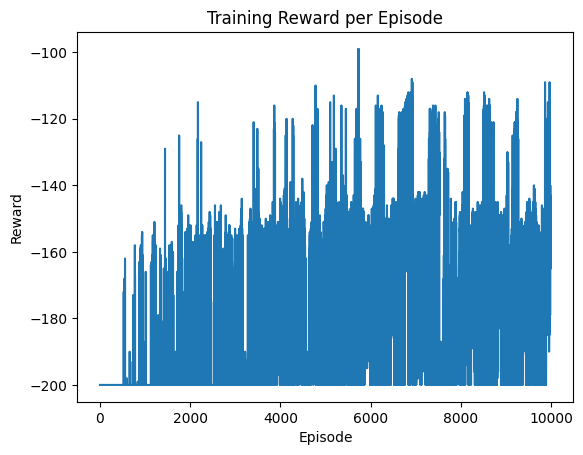

Generating Animation...


In [6]:
def show_animation(frames):
    """Formats a list of frames into a JSHTML animation for Colab."""
    fig = plt.figure(figsize=(5, 4))
    plt.axis('off')
    im = plt.imshow(frames[0])

    def animate(i):
        im.set_array(frames[i])
        return [im]

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
    plt.close()
    return HTML(anim.to_jshtml())

def run_trained_agent(policy):
    """Runs one episode and returns frames for animation."""
    test_env = gym.make(ENV_NAME, render_mode="rgb_array")
    obs, _ = test_env.reset()
    state = discretize(obs)
    frames = []
    done = False

    while not done:
        action = policy[state]
        next_obs, _, terminated, truncated, _ = test_env.step(action)
        frames.append(test_env.render())
        state = discretize(next_obs)
        done = terminated or truncated

    test_env.close()
    return frames

# Plot Rewards
plt.plot(scores)
plt.title("Training Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

# Run and Show Animation
print("Generating Animation...")
frames = run_trained_agent(policy)
display(show_animation(frames))